In [31]:
import pandas as pd
import numpy as np
import geopandas as gpd
# import geodatasets
# import folium
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling

In [32]:
dataset = pd.read_csv('mcmf_all_age_categories_and_zip.csv')
    #This was already processed by another member of the group

#Remove duplicates of program_id
dataset.drop_duplicates(subset=['Program ID'], inplace=True) #This removes 109407 programs

#Discard programs with a minimum age over 25
# dataset = dataset.loc[dataset['Min Age'] <= 25, :] #This doesn't remove anything

# original_dataset = pd.read_csv('My_CHI._My_Future._Programs.csv')

In [33]:
#For 'Capacity', 108880 of 111682 are non-null and 15021 are zero
    #So there are 93859 of 111682 values useful, or 84%. But also 200 of these are one
# dataset.loc[dataset['Capacity'] == 1, 'Capacity'].shape

# Goal 1:
Make a graph of median household income for each zip code

In [34]:
incomes = pd.read_csv('median_chicago_incomes.csv')
chicago = gpd.read_file('Boundaries - ZIP Codes//geo_export_767f7b62-f72f-4fab-a292-28143a93893d.shp')
    #This file is downloaded from data.cityofchicago.org
        #https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-ZIP-Codes/gdcf-axmw

#Merge these two by zip code, but this seems to be tricky so I will take a long-cut using a dictionary
incomes_dict = incomes.set_index('zip')['income_household_median'].to_dict()

def get_incomes(x):
    if int(x) in incomes_dict:
        return incomes_dict[int(x)]
    else:
        return np.nan
#This ended up really only catching zip code 60666 as not having income info
    #This zip code is O'Hare

chicago['income'] = chicago['zip'].apply(get_incomes)

In [35]:
chicago = chicago.loc[chicago['zip'] != '60666']

In [36]:
chicago['zip'].dtype
chicago['income'] = chicago['income'].astype('O')

In [37]:
#specify a color palette for the graph
colors = ['#56d4b2', '#002223']
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

In [38]:
fig, ax = plt.subplots(figsize=(15, 10))

# chicago.plot(column='income', ax=ax, legend=True, legend_kwds={'ncol': 2, 'bbox_to_anchor': (2, 1)})
chicago_plot = chicago.loc[~chicago['income'].isna()]
chicago_plot['income'] = chicago_plot['income'].astype('int')
chicago_plot.plot(column = 'income', ax = ax, legend = True, cmap = cmap) #, legend_kwds={'label': 'Hello'}

# Add title (optional)
plt.title('Median Household Income')
ax.set_axis_off()
# ax.legend(title='Set title', loc='lower center', bbox_to_anchor=(0.5, -0.1))
# plt.colorbar(label = 'Title')
# fig.colorbar(ax=ax, orientation='horizontal', fraction=.1) #images[0], 
# Show the plot
# plt.show()
# plt.savefig(fname ='zip_income.svg', format = 'svg')
plt.close()

# Goal 2:  
Make a plot of the proportion of free programs in each zip code

In [39]:
#Taking only the rows with ZIP code info and only the relevant columns
pricing = dataset.loc[~dataset['ZIP Code'].isna(), 
            ['Capacity', 'ZIP Code', 'Program Price', 
             'Scholarship Available', 'Participants Paid', 'Has Free Food']]

In [40]:
pricing['Free'] = pricing['Program Price'].apply(
    lambda x: x=='Free').astype('int')
prop_free = pd.DataFrame(
    pricing.loc[pricing['Program Price'] != 'Unknown'].groupby(
        by='ZIP Code')['Free'].agg([('Prop. Free', 'mean')])
).reset_index()

In [41]:
#Merge this into the plotting dataframe, by ZIP code
prop_free.rename(columns={'ZIP Code': 'zip'}, inplace=True)
prop_free['zip'] = prop_free['zip'].astype('int')
free_dict = prop_free.set_index('zip')['Prop. Free'].to_dict()
chicago['Prop. Free'] = chicago['zip'].apply(lambda x: free_dict[int(x)])

In [42]:
fig, ax = plt.subplots(figsize=(15, 10))

# chicago.plot(column='income', ax=ax, legend=True, legend_kwds={'ncol': 2, 'bbox_to_anchor': (2, 1)})
chicago_plot = chicago.loc[~chicago['income'].isna()]
chicago_plot['income'] = chicago_plot['income'].astype('int')

#I want the colors to be inverted here, suggesting that a high prop. should align with lower income
cmap_invert = LinearSegmentedColormap.from_list("custom_cmap", colors[::-1])

chicago_plot.plot(column = 'Prop. Free', ax = ax, legend = True, cmap = cmap_invert) 
#, legend_kwds={'label': 'Hello'}

plt.title('Prop. Programs that are Free')
ax.set_axis_off()
# plt.savefig('Prop_free.svg', format = 'svg')
plt.close()

# Goal 3:  
How do median household income and prop. free relate?

My idea here is to make a scatterplot of prop free for each
OR, (unless there are too many zip codes for this to look good), I could make a proportional bar graph of prop free, >50, <50, and unknown
1. Scatter
2. Prop bar graph

In [43]:
#I want a subset that is zip code, prop free, median household income, num programs (including 'unknown' price)

# incomes.head()
program_counts = pd.DataFrame(
    pricing.groupby(by = 'ZIP Code')['Free'].agg([('Num Programs', 'count')])).reset_index()
program_counts.rename(columns={'ZIP Code': 'zip'}, inplace=True)
# prop_free
scatter_data = pd.merge(pd.merge(incomes, program_counts), prop_free)


In [44]:
scatter_data = scatter_data.loc[scatter_data['Num Programs'] >= 20, :] 
    #To note: 60602 only has 41 programs. I want to include this, and am setting the cutoff below this

#Would making the prop bar graph require adding prop >50, prop <50, and prop unknown?

In [45]:
fit_data = scatter_data.loc[scatter_data['zip'] != 60602]
m, b = np.polyfit(fit_data['income_household_median'], fit_data['Prop. Free'], 1)  # Degree 1 for a linear fit
# m, b = coefficients  # m is slope, b is intercept

# # Generate y values for the line of best fit
zip_fit = m * fit_data['income_household_median'] + b
# y_fit = m * x + b

In [46]:
#I want to find the points that are the farthest below this line.
#I'll find the vertical distance (residuals)
# zip_fit
fit_data['Residuals'] = fit_data['Prop. Free'] - zip_fit 
    #And values that are negative here are below the line of best fit
fit_data.sort_values(by = 'Residuals').head()

,zip,income_household_median,Num Programs,Prop. Free,Residuals
43,60645,63488,35,0.088235,-0.506741
26,60626,51562,126,0.161290,-0.466416
18,60618,91650,8972,0.102586,-0.415101
50,60654,127072,524,0.071429,-0.349045
49,60653,34564,909,0.404762,-0.269595


60645, 60626, and 60618 could use the most help here

In [47]:
fig, ax = plt.subplots()
sns.scatterplot(scatter_data, x = 'income_household_median', y = 'Prop. Free', ax = ax, color = colors[0])
ax.plot(fit_data['income_household_median'], zip_fit, color = '#087154',
        label = 'r = -0.38') #, color='red', 
        # label=f'Best Fit Line: y = {m:.2f}x + {b:.2f}')  # Best fit line
ax.set_xlabel('Median Household Income (USD)')
ax.set_ylabel('Proportion of Free Programs')
ax.set_title('Free Programs vs. Income by ZIP Codes')
ax.set_ylim(-0.1, 1.1)
ax.legend()
# fig.savefig('free_by_income.svg', format = 'svg')
plt.close()

In [48]:
#Removing the ZIP code with the highest income (60602), is there a correlation?
print(scatter_data.loc[scatter_data['zip'] != 60602, :].corr()['income_household_median']['Prop. Free'])

-0.37417396895620975


# Goal 3b:  
Prop bar graph

In [93]:
#I want zip code, prop free, prop >50, prop <50, and prop unknown
#But is this gonna look good with 55 different zip codes?? 
    #Maybe if we sort by descending median household income?
# scatter_data.shape

In [133]:
pricing_dummies = pd.concat(
    (pricing.drop(columns = 'Free'), 
     pd.get_dummies(pricing['Program Price'], dtype = int)
     ), axis = 1)

#Remove rows for which the ZIP code has less than 10 programs
counts_by_zip = pd.DataFrame(
    pricing_dummies.groupby(by = 'ZIP Code')['ZIP Code'].agg([('count', 'count')])).reset_index()
too_few_zip = counts_by_zip.loc[counts_by_zip['count'] < 20, 'ZIP Code']
#I want to remove values in pricing_dummies where the ZIP code is in too_few_zip
    #Setting the cutoff to 20 just as before
# pricing_dummies['ZIP Code'].apply(lambda x: x in too_few_zip)
# pricing_dummies.loc[('ZIP Code' in too_few_zip), :]

pricing_dummies = pricing_dummies.loc[~(pricing_dummies['ZIP Code'].isin(too_few_zip)), :]
    #This takes it from 104817 to 104787 values, removing 14 zip codes

#Stacked bar chart!
bar_chart_data = pricing_dummies.groupby(
    by = 'ZIP Code')[['$50 or Less', 'Free','More Than $50','Unknown']].agg('mean').reset_index()

#I want to sort these by ascending income
#To sort by ascending income, I need to add an income column
bar_chart_data['Income'] = bar_chart_data['ZIP Code'].apply(lambda x: incomes_dict.get(x, np.nan))
bar_chart_data = bar_chart_data.loc[~((bar_chart_data['Income']).isna()), :].sort_values(by = 'Income')


In [134]:
color_scheme = ['#c2efe3', '#49d0ac', '#1a6551', '#D0D0D0']
#Free to unknown
# , '#002223'

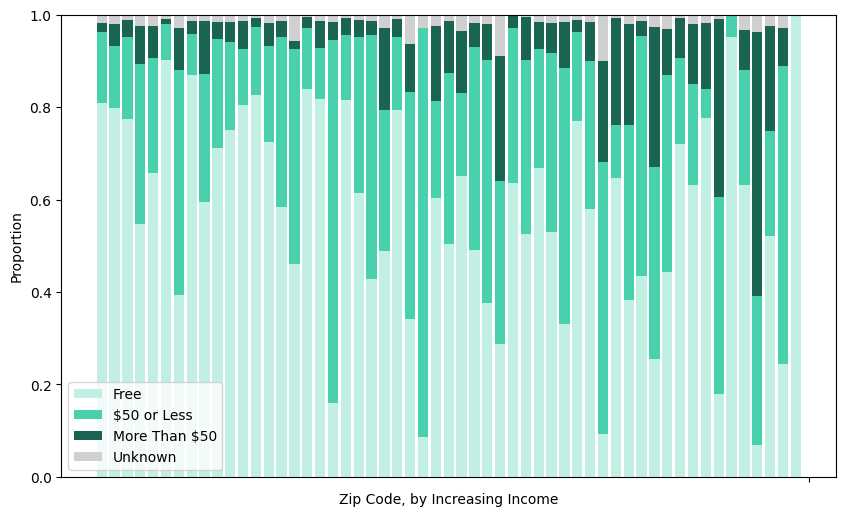

In [136]:
# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each attribute
# attributes = list(bar_chart_data.columns)
# attributes.remove('ZIP Code')
# attributes.remove('Income')
attributes = ['Free', '$50 or Less', 'More Than $50', 'Unknown']

bottom_values = [0] * bar_chart_data.shape[0]
#The x-axis is sorted by increasing income by ZIP code

for i, attr in enumerate(attributes):
    ax.bar(bar_chart_data['ZIP Code'].astype('str'), bar_chart_data[attr], 
           bottom=bottom_values, label=attr, color = color_scheme[i])
    bottom_values += bar_chart_data[attr]

# Add labels and legend
ax.set_xlabel('Zip Code, by Increasing Income')
ax.set_xticks('')
ax.set_ylabel('Proportion')
# ax.set_title('Proportion Bar Graph by Zip Code')
ax.legend()
# plt.savefig('stacked_bar.svg', format = 'svg')
# plt.show()

# Goal 3b.2:
Examine the proportion of paid events that are above or below $50 by zip code. Maybe just a correlation, no visualization.

In [150]:
#pricing_dummies is dummies for the categorical variable of 'Program Price', 
    #zips less than 10 programs removed

#So let's just keep $50 or Less and $50 or More
paid_programs = pricing_dummies.loc[
    (pricing_dummies['$50 or Less'] == 1) | (pricing_dummies['More Than $50'] == 1)]

# paid_programs = paid_programs.groupby(by = 'ZIP Code')['ZIP Code'].agg([('count','count')]).reset_index()
        #For counts by ZIP code, the lowest are 4 and 26. I'll just keep all


In [156]:
below_50 = paid_programs.groupby(by='ZIP Code')['$50 or Less'].agg([('Prop. Below 50', 'mean')]).reset_index() 
below_50['Income'] = bar_chart_data['ZIP Code'].apply(lambda x: incomes_dict.get(x, np.nan))

In [158]:
below_50.corr()

,ZIP Code,Prop. Below 50,Income
ZIP Code,1.000000,0.043514,-0.160471
Prop. Below 50,0.043514,1.000000,-0.317328
Income,-0.160471,-0.317328,1.000000
